## TRANSFER LEARNING: IMPROVING ALGORITHM
---

### Libraries

In [15]:
import pickle
from os import listdir

#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#tensorflow and keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model

#sklearn
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

#open cv
import cv2 as cv

#functions
from utils.images import load_images, read_image_file
from utils.train import series_to_array, get_classes_dictionary

from cascid.configs import config, pad_ufes
from cascid import database

### Constants

In [12]:
# PATH = "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/data/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15
EPOCHS = 250
IMAGE_SHAPE = (128, 128, 3)

FERNANDO_PATH = config.DATA_DIR / 'experiments' / 'fernando'
FERNANDO_PATH.mkdir(exist_ok=True, parents=True)

FULL_DATAFRAME_FILE = FERNANDO_PATH / 'full_dataframe.pkl'
FEATURES_FILE = FERNANDO_PATH / 'features.pkl'

READ_FULL_DATAFRAME = True
COMPUTE_FEATURES = True


### Loading data

In [18]:
def read_images():
    images = []
    file_names = []
    for path in pad_ufes.IMAGES_DIR.glob('*.png'):
        images.append(read_image_file(str(path), IMAGE_SHAPE))
        file_names.append(path.name)
    images_dataframe = pd.DataFrame({
        "image_array": images,
        "img_id": file_names
    })
    return images_dataframe


def read_metadata():
    return database.get_db()


def read_data():
    metadata = read_metadata()
    images_dataframe = read_images()
    full_dataframe = metadata.merge(images_dataframe, how="right", on="img_id")
    return full_dataframe

In [19]:
if READ_FULL_DATAFRAME:
    full_dataframe = read_data()

    with open(FULL_DATAFRAME_FILE, 'wb') as file:
        pickle.dump(full_dataframe, file)
else:
    with open(FULL_DATAFRAME_FILE, 'rb') as file:
        full_dataframe = pickle.load(file)


In [20]:
full_dataframe.head(5).transpose()

,0,1,2,3,4
patient_id,PAT_207,PAT_793,PAT_2088,PAT_1892,PAT_1286
lesion_id,313,1512,4525,3760,999
smoke,True,False,NaN,NaN,NaN
drink,False,False,NaN,NaN,NaN
background_father,PORTUGAL,ITALY,NaN,NaN,NaN
background_mother,PORTUGAL,ITALY,NaN,NaN,NaN
age,79,36,9,39,73
pesticide,True,False,NaN,NaN,NaN
gender,MALE,MALE,NaN,NaN,NaN
skin_cancer_history,False,False,NaN,NaN,NaN


### Test image

In [21]:
img_test = full_dataframe["image_array"][0]
file_test = full_dataframe["img_id"][0]

PAT_207_313_1.png


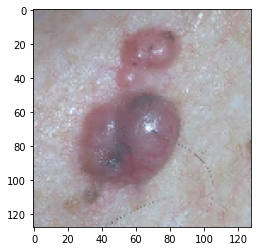

In [22]:
print(file_test)
plt.imshow(img_test)
plt.show()

### Split train, validation and test

In [23]:
features = full_dataframe["image_array"]
target = full_dataframe["diagnostic"]

In [24]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    full_dataframe,
    target="diagnostic",
    train_size=TRAIN_SIZE,
    valid_size=VALIDATION_SIZE,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

print("Train examples: {0}".format(x_train.shape[0]))
print("Validation examples: {0}".format(x_valid.shape[0]))
print("Test examples: {0}".format(x_test.shape[0]))

Train examples: 1608
Validation examples: 345
Test examples: 345


In [25]:
predictions_dictionary = get_classes_dictionary(y_train)

In [26]:
predictions_dictionary

{'BCC': 0, 'SEK': 1, 'NEV': 2, 'ACK': 3, 'SCC': 4, 'MEL': 5}

In [27]:
x_train_to_array = np.asarray(x_train["image_array"].tolist()).astype(
    np.float32)
x_test_to_array = np.asarray(x_test["image_array"].tolist()).astype(np.float32)
x_valid_to_array = np.asarray(x_valid["image_array"].tolist()).astype(
    np.float32)


In [28]:
y_train_to_array = series_to_array(y_train, predictions_dictionary)
y_test_to_array = series_to_array(y_test, predictions_dictionary)
y_valid_to_array = series_to_array(y_valid, predictions_dictionary)


### Data augmentation

In [ ]:
# train_data_augmentation_generator = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
# )

### Model

In [29]:
if COMPUTE_FEATURES:
    feature_extractor = keras.applications.ResNet50(
        weights='imagenet',
        input_shape=IMAGE_SHAPE,
        pooling='avg',
        include_top=False,
    )
    feature_extractor.trainable = False  #to make sure it's not being trained
    features = feature_extractor(x_train_to_array)

    with open(FEATURES_FILE, 'wb') as file:
        pickle.dump(features.numpy(), file)
else:
    with open(FEATURES_FILE, 'rb') as file:
        features = pickle.load(file)

2022-10-03 12:42:44.452819: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-10-03 12:42:44.452862: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cedip
2022-10-03 12:42:44.452870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cedip
2022-10-03 12:42:44.452997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-03 12:42:44.453029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-03 12:42:44.453036: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-03 12:42:44.453259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binar

In [30]:
features.shape

TensorShape([1608, 2048])

In [31]:
input_layer = Input(shape=(2048, ))
output_layer = Dense(6, activation='softmax')(input_layer)
model = Model(input_layer, output_layer)

In [ ]:
# feature_extractor.trainable = False #to make sure it's not being trained
# input_layer = Input(shape=IMAGE_SHAPE)
# pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
# pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
# output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)
# model = Model(input_layer, output_layer)

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 12,294
Trainable params: 12,294
Non-trainable params: 0
_________________________________________________________________


### Train

In [34]:
best_model_checkpoint_early_stopping = EarlyStopping(monitor='val_accuracy',
                                                     mode='max',
                                                     verbose=1,
                                                     patience=100,
                                                     restore_best_weights=True)

best_model_checkpoint = ModelCheckpoint(
    filepath=
    "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test02/model",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True)


In [ ]:
# training_history = model.fit(
#     x = train_data_augmentation_generator.flow(
#         x_train_to_array,
#         y_train_to_array),
#     epochs = EPOCHS,
#     validation_data = (x_valid_to_array, y_valid_to_array),
#     batch_size=8,
#     callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
# )

In [35]:
training_history = model.fit(
    features,
    y_train_to_array,
    epochs=EPOCHS,
    validation_split=0.2,
    batch_size=256,
    #callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
)

Epoch 1/250
6/6 [==============================] - 1s 34ms/step - loss: 1.9450 - accuracy: 0.0964 - val_loss: 1.7422 - val_accuracy: 0.3758
Epoch 2/250
6/6 [==============================] - 0s 7ms/step - loss: 1.6892 - accuracy: 0.3670 - val_loss: 1.5860 - val_accuracy: 0.3758
Epoch 3/250
6/6 [==============================] - 0s 8ms/step - loss: 1.5670 - accuracy: 0.3670 - val_loss: 1.5305 - val_accuracy: 0.3758
Epoch 4/250
6/6 [==============================] - 0s 7ms/step - loss: 1.5260 - accuracy: 0.3670 - val_loss: 1.5203 - val_accuracy: 0.3758
Epoch 5/250
6/6 [==============================] - 0s 7ms/step - loss: 1.5137 - accuracy: 0.3670 - val_loss: 1.5162 - val_accuracy: 0.3758
Epoch 6/250
6/6 [==============================] - 0s 7ms/step - loss: 1.5065 - accuracy: 0.3670 - val_loss: 1.5123 - val_accuracy: 0.3758
Epoch 7/250
6/6 [==============================] - 0s 7ms/step - loss: 1.5031 - accuracy: 0.3670 - val_loss: 1.5102 - val_accuracy: 0.3758
Epoch 8/250
6/6 [=========

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=training_history.history['val_accuracy'],
               mode='lines',
               name='Acc - Validation'))
fig.add_trace(
    go.Scatter(y=training_history.history['accuracy'],
               mode='lines',
               name='Acc - Training'))


In [37]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=training_history.history['val_loss'],
               mode='lines',
               name='Validation loss'))
fig.add_trace(
    go.Scatter(y=training_history.history['loss'],
               mode='lines',
               name='Training loss'))


### Evaluating the model

In [40]:
loss, acc = model.evaluate(x=feature_extractor(x_test_to_array), y=y_test_to_array)
print("model loss: {0}".format(loss))
print("model accuracy: {0}".format(acc))

11/11 [==============================] - 0s 1ms/step - loss: 1.4371 - accuracy: 0.4116
model loss: 1.4371325969696045
model accuracy: 0.4115942120552063


In [42]:
predictions = model.predict(feature_extractor(x_test_to_array))

11/11 [==============================] - 0s 1ms/step


In [43]:
classe_names = y_train.unique().tolist()
classe_names

['BCC', 'SEK', 'NEV', 'ACK', 'SCC', 'MEL']

In [44]:
predictions_categorical = list()
for list_ar in predictions:
    predictions_categorical.append(classe_names[np.argmax(list_ar)])

In [45]:
y_test.value_counts(True)

BCC    0.411594
ACK    0.301449
NEV    0.101449
SEK    0.098551
SCC    0.069565
MEL    0.017391
Name: diagnostic, dtype: float64

In [46]:
pd.Series(predictions_categorical).value_counts(True)

BCC    1.0
dtype: float64